In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from collections import Counter
import unidecode
import seaborn as sns
# modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from scipy import stats
import statsmodels.api as sm 
import time


/home/riisrhavia/.local/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/home/riisrhavia/.local/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess
/home/riisrhavia/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/home/riisrhavia/.local/lib/python2.7/site-packages/sklearn/neighbors/__init__.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .ball_tree import BallTree
/home/riisrhavia/.local/lib/python2.7/site-packages/sklearn/neighbors/__init__.py:7: R

In [2]:
df = pd.read_csv('listings.csv')

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,17878,Very Nice 2Br - Copacabana - WiFi,68997,Matthias,NaN,Copacabana,-22.96592,-43.17896,Entire home/apt,289,5,250,2020-03-04,2.12,1,339
1,21280,Renovated Modern Apt. Near Beach,81163,Jules,NaN,Ipanema,-22.98467,-43.19611,Entire home/apt,406,5,93,2020-03-15,1.25,1,76
2,25026,Beautiful Modern Decorated Studio in Copa,102840,Viviane,NaN,Copacabana,-22.97712,-43.19045,Entire home/apt,162,7,238,2020-02-15,2.00,3,62
3,31560,NICE & COZY 1BDR - IPANEMA BEACH,135635,Renata,NaN,Ipanema,-22.98302,-43.21427,Entire home/apt,330,2,282,2020-03-02,2.39,1,5
4,35636,Cosy flat close to Ipanema beach,153232,Patricia,NaN,Ipanema,-22.98816,-43.19359,Entire home/apt,457,2,179,2020-02-22,2.29,1,169


In [4]:
room_type_df = df.groupby('room_type').id.count()
room_type_df = room_type_df.reset_index()
room_type_df = room_type_df.rename(columns={'id': 'number_of_listings'})
room_type_df

,room_type,number_of_listings
0,Entire home/apt,25838
1,Hotel room,178
2,Private room,9264
3,Shared room,805


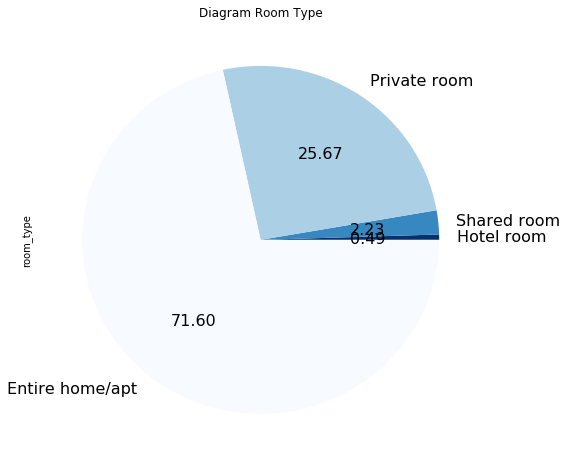

In [5]:
room = df.room_type
r = Counter(room)

# Membuat dataframe baru
room_df = pd.DataFrame.from_dict(r, orient='index').sort_values(by=0)
room_df.columns = ['room_type']

# Plot ke diagram lingkaran
room_df.plot.pie(y = 'room_type', 
                 colormap = 'Blues_r',
                 figsize = (8, 8),
                 fontsize = 16, 
                 autopct = '%.2f',
                 legend = False,
                 title = 'Diagram Room Type')

In [6]:
neigh_df = df.groupby(['neighbourhood', 'room_type']).price.mean()
neigh_df = neigh_df.reset_index()
neigh_df = neigh_df.sort_values('price', ascending=[0])
neigh_df

,neighbourhood,room_type,price
16,Bangu,Entire home/apt,6038.500000
193,Joá,Entire home/apt,5088.537313
52,Campinho,Entire home/apt,4762.500000
245,Padre Miguel,Private room,4334.500000
288,Ramos,Entire home/apt,4258.400000
342,São Conrado,Entire home/apt,3608.185714
291,Realengo,Entire home/apt,3478.500000
276,Praia da Bandeira,Entire home/apt,3044.000000
171,Itanhangá,Entire home/apt,3000.977778
3,Alto da Boa Vista,Entire home/apt,2749.076923


In [7]:
# Remove accents from neighbourhood elements
def remove_accents(a):
    return unidecode.unidecode(a.decode('utf-8'))


df['neighbourhood'] = df['neighbourhood'].apply(remove_accents)

In [8]:
neigh_df = df.groupby(['neighbourhood', 'room_type']).price.mean()
neigh_df = neigh_df.reset_index()
neigh_df = neigh_df.sort_values('price', ascending=[0])
neigh_df

,neighbourhood,room_type,price
18,Bangu,Entire home/apt,6038.500000
195,Joa,Entire home/apt,5088.537313
54,Campinho,Entire home/apt,4762.500000
247,Padre Miguel,Private room,4334.500000
290,Ramos,Entire home/apt,4258.400000
333,Sao Conrado,Entire home/apt,3608.185714
293,Realengo,Entire home/apt,3478.500000
285,Praia da Bandeira,Entire home/apt,3044.000000
173,Itanhanga,Entire home/apt,3000.977778
5,Alto da Boa Vista,Entire home/apt,2749.076923


/home/riisrhavia/.local/lib/python2.7/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


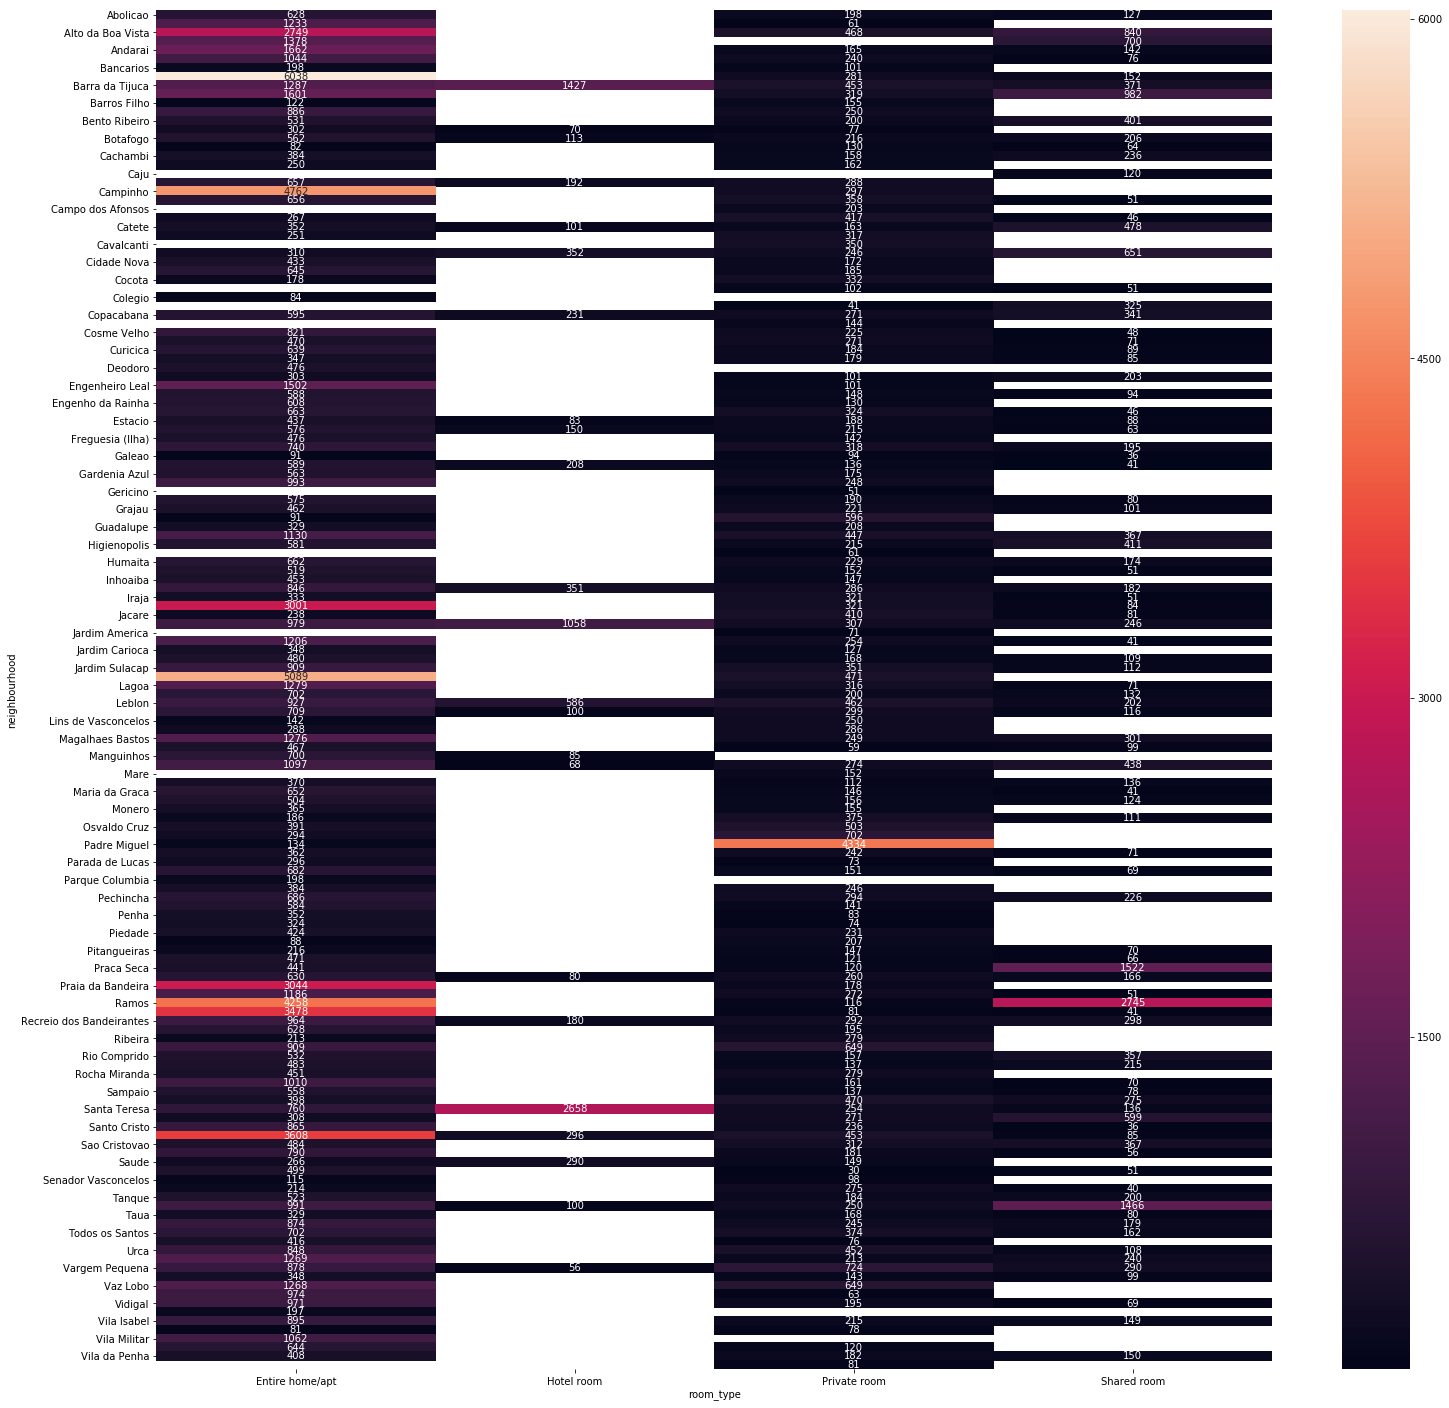

In [9]:
# HeatMap (neighbourhood, room type)x mean price
plt.figure(figsize=(25, 25))
sns.heatmap(df.groupby(['neighbourhood', 'room_type']).price.mean().unstack(), annot=True, fmt=".0f")

In [10]:
# dorp with qualitative atributes
df.drop(['neighbourhood_group', 'id', 'host_id', 'latitude', 'longitude', 'neighbourhood_group'], axis=1, inplace=True)

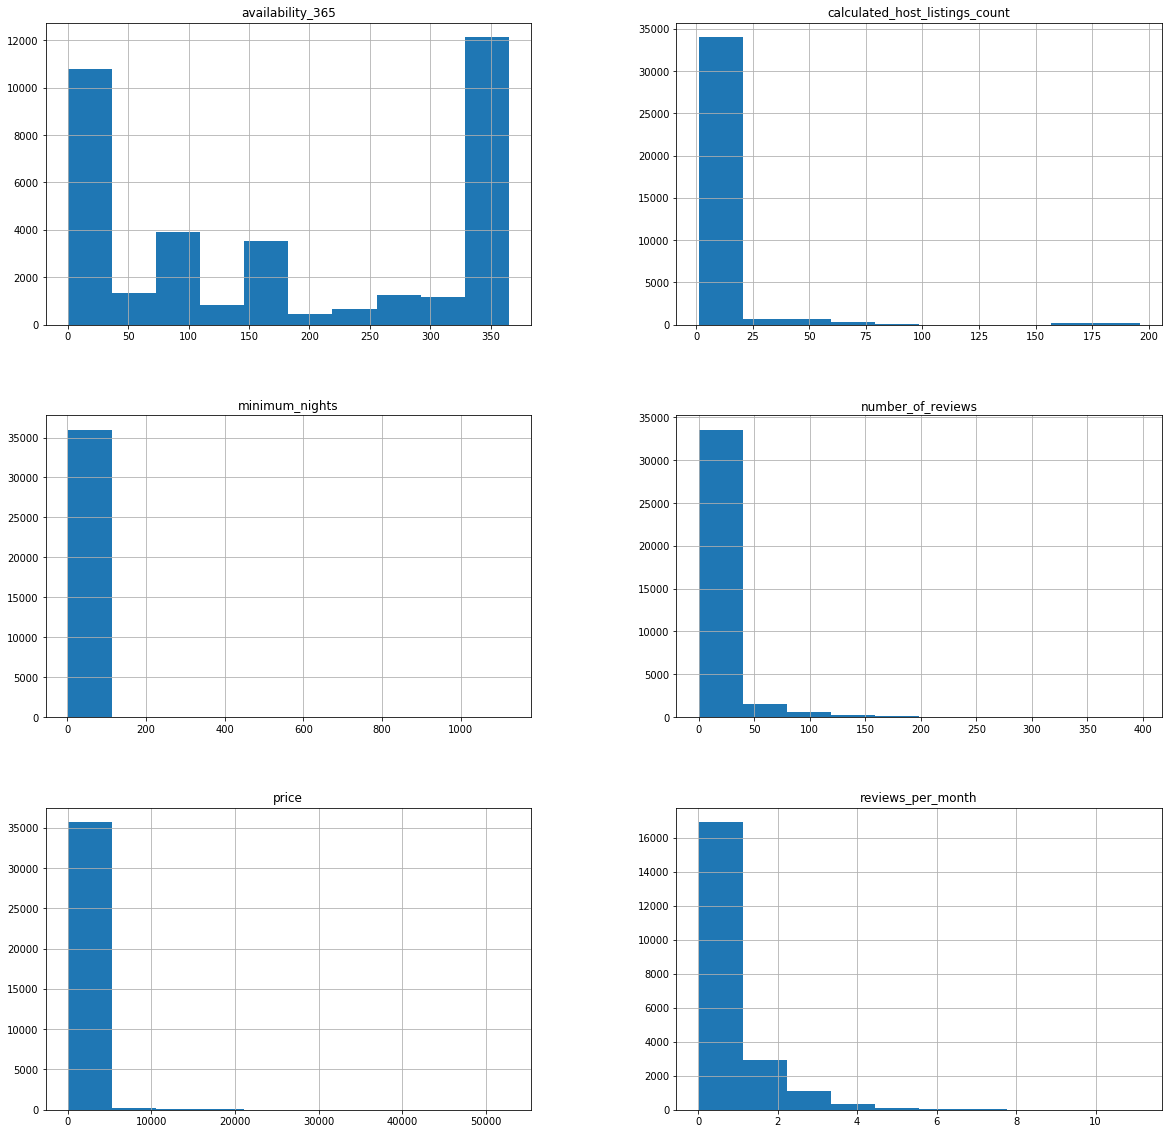

In [11]:
# Plotting the distribution of numerical  categories
df.hist(figsize=(20,20));

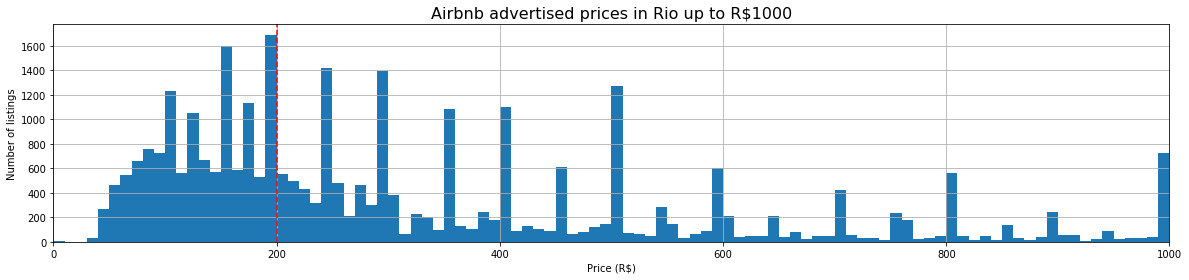

In [12]:
# Distribution of prices from R$0 to R$1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='red', linestyle='--')
plt.title("Airbnb advertised prices in Rio up to R$1000", fontsize=16)
plt.xlabel("Price (R$)")
plt.ylabel("Number of listings")
plt.show()

In [14]:
# Correlation matrix between numerical categories
df.corr()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
price,1.000000,0.027325,-0.076268,-0.065672,0.018707,-0.010576
minimum_nights,0.027325,1.000000,-0.027313,-0.038630,-0.007060,0.011251
number_of_reviews,-0.076268,-0.027313,1.000000,0.548045,-0.023532,0.045923
reviews_per_month,-0.065672,-0.038630,0.548045,1.000000,-0.020122,-0.025208
calculated_host_listings_count,0.018707,-0.007060,-0.023532,-0.020122,1.000000,0.069138
availability_365,-0.010576,0.011251,0.045923,-0.025208,0.069138,1.000000


In [15]:
# Model Prediction of prices in function of numerical categories
X = df[['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']]
Y = df['price']

In [16]:
#Linear multivariate regression
X1 = sm.add_constant(X)
reg = sm.OLS(Y, X1).fit()

reg.summary()

/home/riisrhavia/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     61.95
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           2.92e-52
Time:                        22:18:30   Log-Likelihood:            -3.2393e+05
No. Observations:               36085   AIC:                         6.479e+05
Df Residuals:                   36080   BIC:                         6.479e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            737.3044     16.292     45.256      0.000     705.372     769.237
minimum_nights                     2.2534      0.464      4.859      0.000       1.344       3.162
number_of_reviews                 -5.5650      0.391    -14.223      0.000      -6.332      -4.798
calculated_host_listings_count     1.6474      0.489      3.369      0.001       0.689       2.606
availability_365                  -0.1097      0.067     -1.644      0.100      -0.240       0.021
==============================================================================
Omnibus:                    66502.403   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        107373551.508
Skew:                          13.882   Prob(JB):                         0.00
Kurtosis:                     268.787   Cond. No.                         380.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
#Spliting dataset beteween test and training data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(len(x_train))
print(len(x_test))

25259
10826


In [21]:
# KNN algorithm with 499 first neighbors
knn = KNeighborsRegressor(n_neighbors=499, p=2)
knn.fit(x_train, y_train)
outputs = knn.predict(x_test)
print('Saída esperada: %f' % y_test[0])
print('Saída predita: %f' % outputs[0])

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, outputs)

Saída esperada: 289.000000
Saída predita: 245.879760


3779706.1183817307

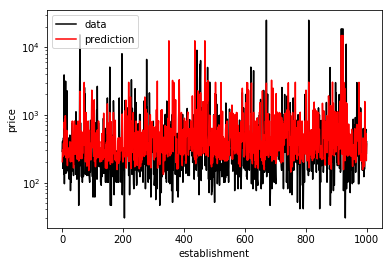

In [25]:
K=9
# Predict the price of 1000 estabilishment
knn = KNeighborsRegressor(n_neighbors=K)
x, y = X[:1000], Y[:1000]
y_ = knn.fit(x, y).predict(x)
plt.plot(np.linspace(0, 1000, 1000), y, label='data', color='black')
plt.plot(np.linspace(0,1000,1000), y_, label='prediction', color='red')
plt.yscale('log')
plt.legend()
plt.xlabel('establishment')
plt.ylabel('price')
plt.show()

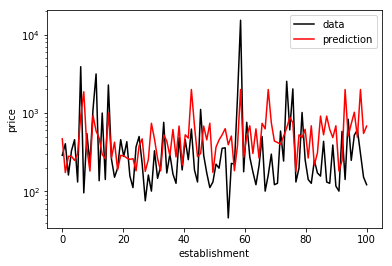

In [26]:
knn = KNeighborsRegressor(n_neighbors=K)
x, y = X[:100], Y[:100]
y_ = knn.fit(x, y).predict(x)
plt.plot(np.linspace(0, 100, 100), y, label='data', color='black')
plt.plot(np.linspace(0,100,100), y_, label='prediction', color='red')
plt.yscale('log')
plt.xlabel('establishment')
plt.ylabel('price')
plt.legend()
plt.show()

[]

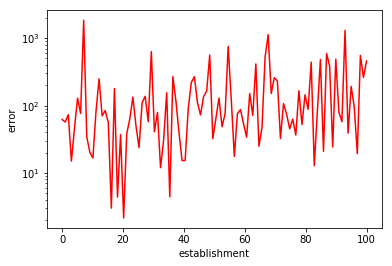

In [27]:
plt.plot(np.linspace(0, 100, 100), np.abs(100*(y_ - y)/y), label='prediction', color='red')
plt.yscale('log')
plt.xlabel('establishment')
plt.ylabel('error')
plt.plot()